<a href="https://colab.research.google.com/github/usm1ai/Accident_Prediction/blob/main/Accident_Pro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

conn = sqlite3.connect('/content/drive/MyDrive/Accident Prediction/accident_data_v1.0.0_2023.db')
cursor = conn.cursor()

# Get all the tables in the database
tables = cursor.execute("SELECT name FROM sqlite_master WHERE type='table';").fetchall()

# Print the table names
for table in tables:
  print(table[0])

accident
casualty
vehicle
lsoa


In [ ]:
'''
Join accident, casualty, and vehicle tables on accident_index.
Then join the resultant table with lsoa using lsoa_of_accident_location
and lsoa01cd
'''

joined_table = pd.read_sql_query("""
SELECT *
FROM accident
INNER JOIN casualty ON accident.accident_index = casualty.accident_index
INNER JOIN vehicle ON accident.accident_index = vehicle.accident_index
INNER JOIN lsoa ON accident.lsoa_of_accident_location = lsoa.lsoa01cd
WHERE accident.accident_year = 2020
""", conn)

# Print the joined table
# print(joined_table.head())

conn.close()


In [ ]:
# Delete duplicate columns
joined_table = joined_table.loc[:,~joined_table.columns.duplicated()]


In [ ]:
joined_table

,accident_index,accident_year,accident_reference,location_easting_osgr,location_northing_osgr,longitude,latitude,police_force,accident_severity,number_of_vehicles,...,generic_make_model,driver_imd_decile,driver_home_area_type,objectid,lsoa01cd,lsoa01nm,lsoa01nmw,shape__area,shape__length,globalid
0,2020010219808,2020,010219808,521389.0,175144.0,-0.254001,51.462262,1,3,1,...,AUDI Q5,4,1,4576,E01004576,Wandsworth 013D,Wandsworth 013D,4.456251e+05,4486.701130,c7ddebfb-d730-4be6-b67e-938adb21309e
1,2020010220496,2020,010220496,529337.0,176237.0,-0.139253,51.470327,1,3,1,...,AUDI A1,7,1,3034,E01003034,Lambeth 012A,Lambeth 012A,1.146984e+05,1719.140860,cb2e7f50-252f-469e-9b13-a56794f5d5d6
2,2020010220496,2020,010220496,529337.0,176237.0,-0.139253,51.470327,1,3,1,...,AUDI A1,7,1,3034,E01003034,Lambeth 012A,Lambeth 012A,1.146984e+05,1719.140860,cb2e7f50-252f-469e-9b13-a56794f5d5d6
3,2020010228005,2020,010228005,526432.0,182761.0,-0.178719,51.529614,1,3,1,...,-1,-1,-1,4726,E01004726,Westminster 003C,Westminster 003C,1.857269e+05,2698.692831,e5cccc5e-7d0c-4f89-82c3-2a5d03b1ae18
4,2020010228006,2020,010228006,538676.0,184371.0,-0.001683,51.541210,1,2,1,...,TOYOTA PRIUS,2,1,3617,E01003617,Newham 012B,Newham 012B,2.326906e+05,3013.438191,3e1979c9-8863-4982-afa5-7a6de00635d7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201938,202063DF01620,2020,63DF01620,324280.0,259980.0,-3.110141,52.232798,63,1,4,...,AUDI A3,6,3,32966,W01000484,Powys 011E,Powys 011E,1.535530e+08,81092.977857,629864d0-e8b8-41a9-aa65-d8ea28fc6eef
201939,202063DF01620,2020,63DF01620,324280.0,259980.0,-3.110141,52.232798,63,1,4,...,FORD FOCUS,6,3,32966,W01000484,Powys 011E,Powys 011E,1.535530e+08,81092.977857,629864d0-e8b8-41a9-aa65-d8ea28fc6eef
201940,202063DF01620,2020,63DF01620,324280.0,259980.0,-3.110141,52.232798,63,1,4,...,MITSUBISHI SHOGUN,7,3,32966,W01000484,Powys 011E,Powys 011E,1.535530e+08,81092.977857,629864d0-e8b8-41a9-aa65-d8ea28fc6eef
201941,202063DF01620,2020,63DF01620,324280.0,259980.0,-3.110141,52.232798,63,1,4,...,BMW 3 SERIES,6,2,32966,W01000484,Powys 011E,Powys 011E,1.535530e+08,81092.977857,629864d0-e8b8-41a9-aa65-d8ea28fc6eef


In [ ]:
# # Save file as csv
# joined_table.to_csv('/content/drive/MyDrive/Accident Prediction/joined_table_.csv', index=False)

In [ ]:
def time_of_the_day_analysis(time_pred):
  time_pred = pd.DataFrame(time_pred.str.split(':').str[0].astype(int))
  # Count occurrences of accidents for each hour
  hourly_accidents = time_pred.value_counts().sort_index()

  # Plotting
  plt.figure(figsize=(10, 6))
  hourly_accidents.plot(kind='bar', color='skyblue')
  plt.title('Accidents by Hour of the Day')
  plt.xlabel('Hour')
  plt.ylabel('Number of Accidents')

  # Set the x-axis tick labels
  plt.xticks(range(24), range(0, 24))  # Assuming 24 hours, starting from 1
  plt.xticks(rotation=0)  # Rotate x-axis labels if needed

  plt.grid(axis='y', linestyle='--', alpha=0.7)
  # plt.savefig('/content/drive/MyDrive/Accident Prediction/accidents_by_hour.png')
  plt.show()

In [ ]:
def day_of_the_week_analysis(day_pred):
  # Count occurrences of accidents for each hour
  days = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
  daily_accidents = day_pred.value_counts().sort_index()

  # Plotting
  plt.figure(figsize=(10, 6))
  daily_accidents.plot(kind='bar', color='skyblue')
  plt.title('Accidents by Day of the Week')
  plt.xlabel('Day')
  plt.ylabel('Number of Accidents')

  # Set the x-axis tick labels
  # plt.xticks(range(7), range(0, 7))
  plt.xticks(range(7), days)
  plt.xticks(rotation=0)  # Rotate x-axis labels if needed

  plt.grid(axis='y', linestyle='--', alpha=0.7)
  # plt.savefig('/content/drive/MyDrive/Accident Prediction/accidents_by_day.png')
  plt.show()


In [ ]:
t = joined_table['time'].copy()

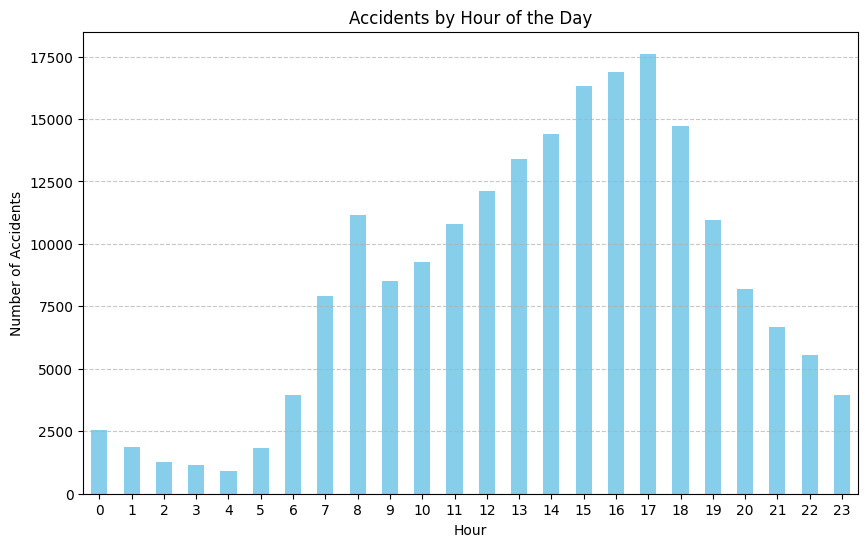

In [ ]:
time_of_the_day_analysis(t)

In [ ]:
d = joined_table['day_of_week'].copy()

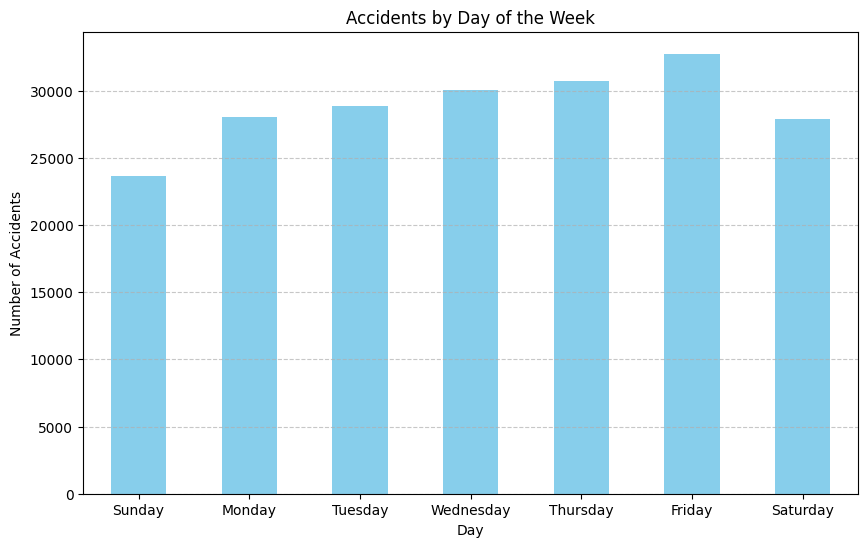

In [ ]:
day_of_the_week_analysis(d)

In [ ]:
# For Motorcycles

In [ ]:
'''
Filter rows where vehicle_type is 2, 3, 4, or 5

2 --> 50CC or under
3 --> 50CC to 125CC
4 --> 125CC to 500CC
5 --> Above 500CC

'''

filtered_table = joined_table[joined_table['vehicle_type'].isin([2, 3, 4, 5])]
# Select only the columns of interest
filtered_data = filtered_table[['vehicle_type', 'time', 'day_of_week']].reset_index(drop=True)
# Display the filtered data
filtered_data

,vehicle_type,time,day_of_week
0,3,03:25,4
1,2,08:00,4
2,3,14:00,4
3,3,14:37,4
4,3,19:05,4
...,...,...,...
14306,5,12:27,1
14307,5,12:27,1
14308,5,15:05,1
14309,5,17:00,6


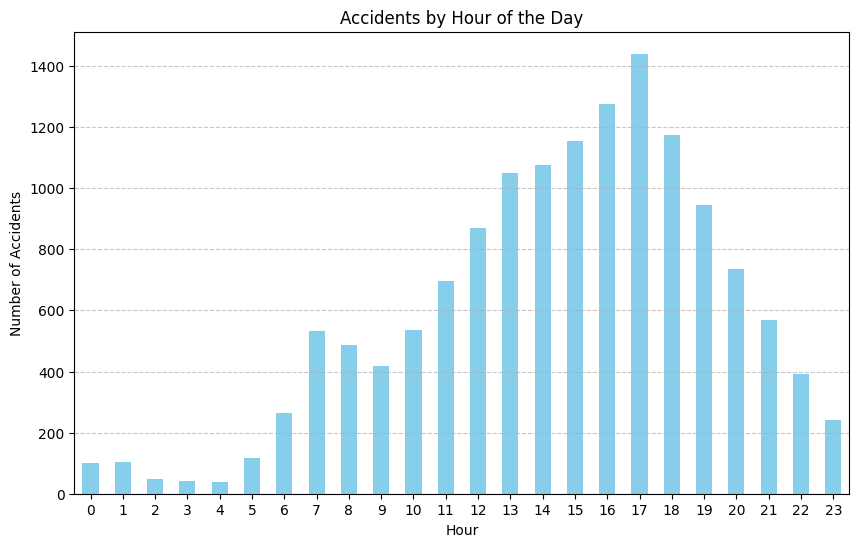

In [ ]:
time_of_the_day_analysis(filtered_data['time'])

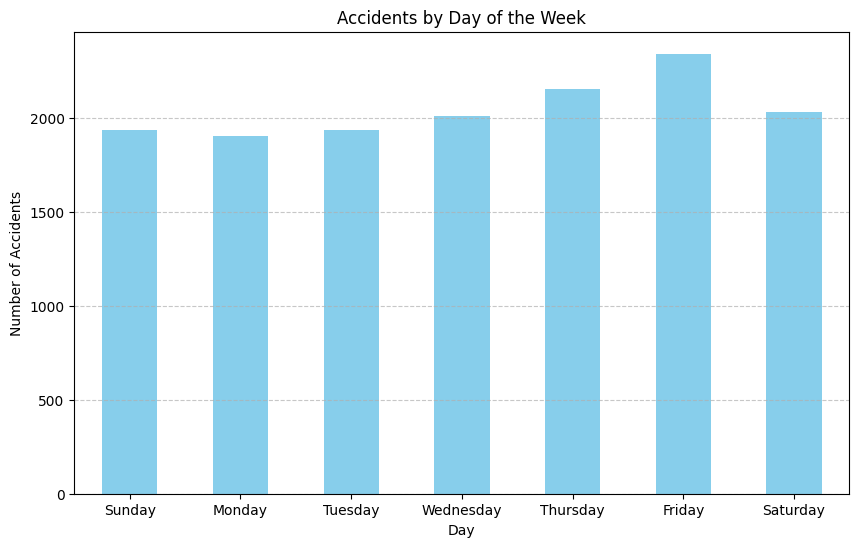

In [ ]:
day_of_the_week_analysis(filtered_data['day_of_week'])